In [9]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import torch
import torch.nn as nn
import torch.nn.functional as F
from main_monodepth_pytorch import Model
%reload_ext autoreload
%autoreload 2

## Train

Check if CUDA is available

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.cuda.device_count()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dict_parameters = edict({'data_dir':'data/kitti/train/',
                         'val_data_dir':'data/kitti/val/',
                         'model_path':'data/models/monodepth_resnet18_001.pth',
                         'output_directory':'data/output/',
                         'input_height':256,
                         'input_width':512,
                         'model':'resnet18_md',
                         'pretrained':True,
                         'mode':'train',
                         'epochs':200,
                         'learning_rate':1e-4,
                         'batch_size': 8,
                         'adjust_lr':True,
                         'device':'cuda:0',
                         'do_augmentation':True,
                         'augment_parameters':[0.8, 1.2, 0.5, 2.0, 0.8, 1.2],
                         'print_images':False,
                         'print_weights':False,
                         'input_channels': 3,
                         'num_workers': 8,
                         'use_multiple_gpu': False})

In [ ]:
model = Model(dict_parameters)
#model.load('data/models/monodepth_resnet18_001_last.pth')

In [ ]:
model.train()

## Test the model

In [2]:
dict_parameters_test = edict({'data_dir':'data/test',
                              'model_path':'data/model/monodepth_resnet18_001.pth',
                              'output_directory':'data/output/',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':False,
                              'mode':'test',
                              'device':'cuda:0',
                              'input_channels':3,
                              'num_workers':4,
                              'use_multiple_gpu':False})
model_test = Model(dict_parameters_test)

Use a dataset with 108 images


In [35]:
model_test.test()

Finished Testing


In [36]:
disp = np.load('data/output/disparities_pp.npy')  # Or disparities.npy for output without post-processing
disp.shape

(108, 256, 512)

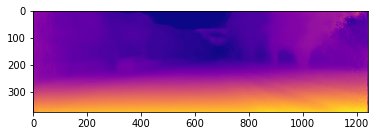

In [62]:
## disp_to_img = skimage.transform.resize(disp[0].squeeze(), [375, 1242], mode='constant')
plt.imshow(disp_to_img, cmap='plasma')

Save a color image

In [ ]:
plt.imsave(os.path.join(dict_parameters_test.output_directory,
                        dict_parameters_test.model_path.split('/')[-1][:-4]+'_test_output.png'), disp_to_img, cmap='plasma')

Save all test images

In [ ]:
for i in range(disp.shape[0]):
    disp_to_img = skimage.transform.resize(disp[i].squeeze(), [375, 1242], mode='constant')
    plt.imsave(os.path.join(dict_parameters_test.output_directory,
               'pred_'+str(i)+'.png'), disp_to_img, cmap='plasma')

Save a grayscale image

In [ ]:
plt.imsave(os.path.join(dict_parameters_test.output_directory,
                        dict_parameters_test.model_path.split('/')[-1][:-4]+'_gray.png'), disp_to_img, cmap='gray')

In [86]:
from data_loader import KittiLoader
from torch.utils.data import DataLoader, ConcatDataset
from transforms import image_transforms

In [100]:
data_directory = 'data/test/'
data_dirs = os.listdir(data_directory)

data_transform = image_transforms(
    mode='test')
datasets = [KittiLoader(os.path.join(data_directory,
                            data_dir), 'test', transform=data_transform)
                            for data_dir in data_dirs]


In [104]:
dataset = ConcatDataset(datasets)

In [110]:
len(dataset)

108

In [3]:
for (i, data) in enumerate(model_test.loader):
    # Get the inputs
#     data = to_device(data,'cuda:0')
    print(len(data))
    left = data.squeeze()
    # Do a forward pass
    break

1


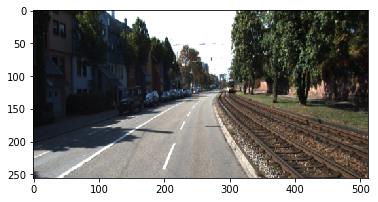

In [4]:
sdata = data[0,0,:,:,:]
plt.imshow(np.array(sdata).transpose(1,2,0))

In [24]:
img = sdata

In [18]:
def gradient_x( img):
    # Pad input to keep output size consistent
    img = F.pad(img, (0, 1, 0, 0), mode="replicate")
    gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
    return gx

In [16]:
F.pad(sdata, (0, 0, 0, 0), mode="replicate").shape

torch.Size([2, 3, 256, 512])

In [25]:
batch_size, _, height, width = img.size()
x_base = torch.linspace(0, 1, width).repeat(batch_size,
            height, 1).type_as(img)

In [28]:
y_base = torch.linspace(0, 1, height).repeat(batch_size,
                    width, 1).transpose(1, 2).type_as(img)

In [32]:
x_shifts = sdata[:, 0, :, :]

In [33]:
flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)

In [36]:
output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear',
                       padding_mode='zeros')

In [37]:
output.shape

torch.Size([2, 3, 256, 512])

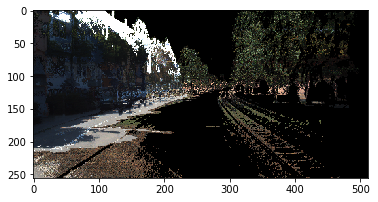

In [38]:
plt.imshow(np.array(output[0]).transpose(1,2,0))

In [49]:
g = torch.from_numpy(np.array([[1.0,2,3,4],[-5,-6,-7,-8]]))

In [51]:
torch.mean(torch.abs(g), 1, keepdim=True)

tensor([[2.5000],
        [6.5000]], dtype=torch.float64)

In [52]:
torch.abs(g)

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]], dtype=torch.float64)

In [58]:
torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) 

tensor([[0.0821],
        [0.0015]], dtype=torch.float64)

In [56]:
g*torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) 

tensor([[ 0.0821,  0.1642,  0.2463,  0.3283],
        [-0.0075, -0.0090, -0.0105, -0.0120]], dtype=torch.float64)